# setup

In [1]:
import os, re, json, glob, math, sys, random
from pathlib import Path
from typing import Dict, Iterable, Optional, Sequence, Tuple, Set
from collections import defaultdict, Counter, deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, ScalarFormatter

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Subset

# ----------------------------
# Project root (repo)
# ----------------------------
#PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/Bio_ontology/MicrobeAtlas/OTU-TAXA-FOUNDATION").resolve()
PROJ_ROOT = Path("/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation")
SRC_DIR = PROJ_ROOT / "src"

if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

# ----------------------------
# Local package imports (src/otu_taxa)
# ----------------------------
from otu_taxa.dataloaders_unk_balanced import (
    OTUTaxaDataset,
    MaskingConfig,
    make_tax_only_mask_collator,
)

from otu_taxa.helpers_taxa_prediction import (
    load_vocab_json,
    norm_id,
    parse_tax_to_cols,
    is_unknown,
    evaluate_and_plot_predictions,
)

# UNK-aware metrics / decoding helpers
from otu_taxa.joint_hier_loss_metrics_unk import (
    hierarchical_predict_full_path,
    make_factorized_tax_loss_fn_fast_masked_with_unk,
    get_tax_path_for_label,
    deepest_taxonomy_accuracy_f1,   # often useful in testing
)

# UNK-aware model
from otu_taxa.otu_taxa_transformer_unk import (
    ModelConfig,
    OTUTaxaTransformerEmbedTaxTreeUnkTaxa,
)
from otu_taxa.helpers_pretraining_model import IGNORE_INDEX, set_seed




# load model

In [ ]:
# ---------------------------
# Run paths (inside repo)
# ---------------------------
run_name = "pretrain_hier_joint_unk_taxa"
RUN_DIR   = os.path.join(PROJ_ROOT, "runs_microbeatlas", run_name)
META_PATH = os.path.join(RUN_DIR, "meta.json")
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")

with open(META_PATH, "r") as f:
    meta = json.load(f)

# ---------------------------
# External (heavy) dataset location (outside repo)
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # prefer meta if saved

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

SAMPLES_JSONL = os.path.join(dataset_dir, "samples.jsonl")
TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")

assert os.path.isfile(SAMPLES_JSONL), f"Missing samples.jsonl: {SAMPLES_JSONL}"
assert os.path.isdir(TREE_DIR), f"Missing tree_artifacts dir: {TREE_DIR}"

print("[INFO] dataset_dir:", dataset_dir)

[INFO] dataset_dir: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999


In [ ]:
# ---------------------------
# Rebuild EXACT split used in tail-OTU heldout training (from saved JSON)
# Train = samples with NONE of the selected OTUs  (precomputed indices)
# Test  = held-out samples with >=1 selected OTU (precomputed indices)
# Val   = random subset of Train (clean validation)
# ALSO: load selected_otus for masking/eval later
# ---------------------------

seed = meta.get("seed", 123)
set_seed(seed)
random.seed(seed)

ds = OTUTaxaDataset(dataset_dir)
N = len(ds)
print(f"[INFO] Dataset size: N={N}")

# ---- split file  ----
SPLIT_JSON = "/home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/notebooks/test_k_shot/split_tail80_nOTU200_seed123.json"

with open(SPLIT_JSON, "r") as f:
    split = json.load(f)

# indices used during training
train_idx   = sorted(split["train_indices"])
heldout_idx = sorted(split["heldout_indices"])   # becomes TEST set now

# OTU pool used to define the split
selected_otus = split["selected_otus"]
selected_otus_set = set(selected_otus)

# ---- safety checks ----
assert len(train_idx) + len(heldout_idx) == N, "Split indices do not sum to N"
assert set(train_idx).isdisjoint(set(heldout_idx)), "Train/Heldout overlap detected"

print(f"[SPLIT:TAIL] Train(clean)={len(train_idx)}  Heldout={len(heldout_idx)}  (Total N={N})")
print(f"[SPLIT:TAIL] Heldout fraction = {len(heldout_idx)/N:.4f}")

# ---- build VAL from train_idx  ----
VAL_N = meta.get("VAL_N", 20_000)    # keep meta logic
VAL_N = min(VAL_N, len(train_idx))

train_idx_shuf = train_idx.copy()
random.shuffle(train_idx_shuf)

val_idx         = sorted(train_idx_shuf[:VAL_N])
train_idx_final = sorted(train_idx_shuf[VAL_N:])

test_idx = heldout_idx

print(f"[SPLIT:FINAL] Train={len(train_idx_final)}  Val={len(val_idx)}  Test(heldout)={len(test_idx)}")

train_ds = Subset(ds, train_idx_final)
val_ds   = Subset(ds, val_idx)
test_ds  = Subset(ds, test_idx)

# ---- optional reporting  ----
print("\n[OTU POOL INFO]")
print(f"  tail_quantile: {split['tail_quantile']}")
print(f"  threshold_samples: {split['threshold_samples']}")
print(f"  n_sampled_otus: {split['n_sampled_otus']}")
print(f"  seed: {split['seed']}")
print(f"  selected_otus: {len(selected_otus)} (preview: {selected_otus[:15]})")


[INFO] Dataset size: N=1836250
[SPLIT:TAIL] Train(clean)=1651900  Heldout=184350  (Total N=1836250)
[SPLIT:TAIL] Heldout fraction = 0.1004
[SPLIT:FINAL] Train=1631900  Val=20000  Test(heldout)=184350

[OTU POOL INFO]
  tail_quantile: 0.8
  threshold_samples: 4445
  n_sampled_otus: 200
  seed: 123
  selected_otus: 200 (preview: [33840, 42904, 14141, 28358, 46076, 20141, 50168, 26981, 61167, 45753, 35330, 27457, 31448, 34015, 37095])


In [ ]:
DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ---------------------------
# Experiment & run names (NEW layout)
# ---------------------------
run_name = "pretrain_tail_80_otus_200"
experiment_name = "runs_microbeatlas_k_shot"

RUN_DIR   = os.path.join(PROJ_ROOT, experiment_name, run_name)
CKPT_PATH = os.path.join(RUN_DIR, "best.pt")
META_PATH = os.path.join(RUN_DIR, "meta.json")

# ---------------------------
# 1) meta.json strict load  (MOVE UP so dataset_dir matches training)
# ---------------------------
with open(META_PATH, "r") as f:
    meta = json.load(f)

mc = meta.get("model_cfg")
if mc is None:
    raise KeyError("meta.json must contain 'model_cfg'.")

required_mc = ["d_model", "n_layers", "n_heads", "d_ff", "dropout", "activation"]
missing = [k for k in required_mc if k not in mc]
if missing:
    raise KeyError(f"meta['model_cfg'] missing required keys: {missing}")

# ---------------------------
# Full MicrobeAtlas dataset path (EXACT training logic)
# ---------------------------
DATASET_ROOT = "/home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training"
dataset_folder_name = meta.get("dataset_folder_name", "dataset_full_top999")  # <-- CHANGED

dataset_dir = os.path.join(
    DATASET_ROOT,
    "level_97",
    "silva-138.2",
    "incomplete_silva_sintax",
    dataset_folder_name,
)

TREE_DIR = os.path.join(dataset_dir, "tree_artifacts")
UNK_VOCAB_PATH = os.path.join(TREE_DIR, "taxonomy_vocab_with_unk.json")
UNK_M_PATH     = os.path.join(TREE_DIR, "descendant_matrix_with_unk.npy")
RANK_IDX_PATH  = os.path.join(TREE_DIR, "rank_idx.npy")

# ---------------------------
# Output location for predictions
# ---------------------------
OUT_DIR = Path(dataset_dir) / "predictions_of_taxa" / experiment_name / run_name
OUT_DIR.mkdir(parents=True, exist_ok=True)

# if Cell 2 loaded `split`, use it to name output (you said now you care about selected OTUs)
OUT_JSONL = OUT_DIR / f"pred_tail{int(100*split['tail_quantile'])}_nOTU{split['n_sampled_otus']}_seed{split['seed']}_affected_taxonomy.jsonl"

# ---------------------------
# 2) dataset sizes + strict consistency checks
# ---------------------------
ds = OTUTaxaDataset(dataset_dir)
O_ds = ds.O
T_real_ds = ds.T

ds_meta = meta.get("dataset", {})
if not ds_meta:
    raise KeyError("meta.json must contain 'dataset' with O/T info.")

mO     = ds_meta.get("O")
T_real = ds_meta.get("T_real")
T_base = ds_meta.get("T_base")

if mO is None or T_real is None or T_base is None:
    raise KeyError("meta['dataset'] must contain 'O', 'T_real', 'T_base'.")

if mO != O_ds:
    raise ValueError(f"Dataset O mismatch: meta O={mO}, dataset O={O_ds}")

if T_real != T_real_ds:
    raise ValueError(f"Dataset T_real mismatch: meta T_real={T_real}, dataset T={T_real_ds}")

pad_otu_id  = O_ds
mask_otu_id = O_ds + 1

pad_tax_id  = T_base
mask_tax_id = T_base + 1

n_otus = O_ds + 2
n_taxa = T_base + 2

# ---------------------------
# 3) Load UNK tree artifacts required for hierarchical loss/decoding
# ---------------------------
with open(UNK_VOCAB_PATH, "r") as f:
    tax_vocab_unk = json.load(f)
if len(tax_vocab_unk) != T_base:
    raise ValueError(f"UNK vocab length mismatch: len(vocab_unk)={len(tax_vocab_unk)} vs T_base={T_base}")

M_np = np.load(UNK_M_PATH)
if M_np.shape != (T_base, T_base):
    raise ValueError(f"Descendant matrix shape mismatch: {M_np.shape} vs expected {(T_base, T_base)}")

rank_idx = np.load(RANK_IDX_PATH)
if rank_idx.shape[0] != T_base:
    raise ValueError(f"rank_idx length mismatch: {rank_idx.shape} vs T_base={T_base}")

M_tensor = torch.from_numpy(M_np).to(DEVICE)
rank_idx_t = torch.from_numpy(rank_idx).to(DEVICE)

# ---------------------------
# 4) Build loss fn (keeps model construction identical to training)
# ---------------------------
hier_tax_loss_fn = make_factorized_tax_loss_fn_fast_masked_with_unk(
    M_tensor=M_tensor,
    rank_idx=rank_idx_t,
    tax_vocab=tax_vocab_unk,
    T_base=T_base,
)

# ---------------------------
# 5) Instantiate model exactly and strict checkpoint load
# ---------------------------
cfg = ModelConfig(**mc)

model = OTUTaxaTransformerEmbedTaxTreeUnkTaxa(
    n_otus=n_otus,
    n_taxa=n_taxa,
    pad_otu_id=pad_otu_id,
    pad_tax_id=pad_tax_id,
    config=cfg,
    tax_loss_fn=hier_tax_loss_fn,
)

raw = torch.load(CKPT_PATH, map_location="cpu")
if not isinstance(raw, dict):
    raise TypeError("Checkpoint must be a dict-like object.")

if "model" in raw and isinstance(raw["model"], dict):
    sd = raw["model"]
elif "state_dict" in raw and isinstance(raw["state_dict"], dict):
    sd = raw["state_dict"]
else:
    raise KeyError("Checkpoint must contain either 'model' or 'state_dict'.")

def strip_prefix_if_all(state_dict, prefix: str):
    keys = list(state_dict.keys())
    if keys and all(k.startswith(prefix) for k in keys):
        return {k[len(prefix):]: v for k, v in state_dict.items()}
    return state_dict

sd = strip_prefix_if_all(sd, "model.")
sd = strip_prefix_if_all(sd, "module.")

model.load_state_dict(sd, strict=True)
model.to(DEVICE).eval()

print("[OK] strict load succeeded; model on", DEVICE)
print(f"[INFO] dataset_dir={dataset_dir}")
print(f"[INFO] O={O_ds}, T_real={T_real}, T_base={T_base}, n_taxa={n_taxa}")
print(f"[INFO] OUT_JSONL={OUT_JSONL}")


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7108d227f730>>
Traceback (most recent call last):
  File "/home/hernan_melmoth/anaconda3/envs/bio_ontology_env/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


In [ ]:
# -----------------------------------
# Build tax_id2name mapping (GLOBAL)
# -----------------------------------
# taxonomy_vocab_with_unk.json can be either:
#   - list[str]          (index = tax_id)
#   - dict[str/int -> str]

if isinstance(tax_vocab_unk, list):
    tax_id2name = {i: name for i, name in enumerate(tax_vocab_unk)}

elif isinstance(tax_vocab_unk, dict):
    # ensure integer keys
    tax_id2name = {int(k): v for k, v in tax_vocab_unk.items()}

else:
    raise TypeError(
        f"Unsupported taxonomy vocab type: {type(tax_vocab_unk)}"
    )

# strict sanity check
if len(tax_id2name) != T_base:
    raise ValueError(
        f"tax_id2name size mismatch: "
        f"len={len(tax_id2name)} vs T_base={T_base}"
    )

print(f"[INFO] tax_id2name created (size={len(tax_id2name)})")
print(f"[INFO] preview taxonomy names: {[tax_id2name[i] for i in range(min(5, T_base))]}")

[INFO] tax_id2name created (size=6935)
[INFO] preview taxonomy names: ['c:028H05-P-BN-P5', 'c:055B07-P-DI-P58', 'c:113B434', 'c:AB64A-17', 'c:AEGEAN-245']


# Predictions

In [ ]:
# ---------------------------------------------------------
# 0) Reproducibility for the OTU selection step
# ---------------------------------------------------------
seed = meta.get("seed", 123)
random.seed(seed)

# ---------------------------------------------------------
# 1) OTU vocab mappings (keep as-is)
# ---------------------------------------------------------
otu_vocab_candidates = [
    os.path.join(dataset_dir, "otu_vocab.json"),
    os.path.join(TREE_DIR, "otu_vocab.json"),
]
otu_vocab_path = next((p for p in otu_vocab_candidates if os.path.isfile(p)), None)

otu_id2name = None
otu_name2id = None
if otu_vocab_path is not None:
    with open(otu_vocab_path, "r") as f:
        otu_vocab = json.load(f)
    if isinstance(otu_vocab, dict):
        otu_id2name = {int(k): v for k, v in otu_vocab.items()}
        otu_name2id = {v: k for k, v in otu_id2name.items()}
    elif isinstance(otu_vocab, list):
        otu_id2name = {i: n for i, n in enumerate(otu_vocab)}
        otu_name2id = {n: i for i, n in otu_id2name.items()}
    print(f"[INFO] Loaded OTU vocab: {otu_vocab_path}  (size={len(otu_id2name)})")
else:
    print("[WARN] OTU vocab json not found; proceeding without names (IDs only).")

# ---------------------------------------------------------
# 2) Sanity check dataset sizes (keep as-is)
# ---------------------------------------------------------
O_eval, T_real_eval = ds.O, ds.T
if O_eval != O_ds:
    raise ValueError(f"OTU mismatch: model block O={O_ds}, dataset O={O_eval}")
if T_real_eval != T_real:
    raise ValueError(f"T_real mismatch: model meta T_real={T_real}, dataset T={T_real_eval}")

print(f"[INFO] Eval setup: O={O_eval}, T_real={T_real_eval}, T_base={T_base}")

# ---------------------------------------------------------
# 3) Build OTU *counts* from test_ds (optional, for reporting only)
#    Keep your existing helper because you use otu_counts later.
# ---------------------------------------------------------
def build_otu_pool_from_subset(subset_ds, otu_key="otus", probe=None, return_counts=True):
    pool = set()
    counts = Counter()
    n_seen = 0

    L = len(subset_ds)
    limit = L if probe is None else min(L, int(probe))

    for i in range(limit):
        rec = subset_ds[i]
        otus = rec[otu_key]
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()
        for o in otus:
            oi = int(o)
            pool.add(oi)
            if return_counts:
                counts[oi] += 1
        n_seen += 1

    return (pool, counts, n_seen) if return_counts else (pool, n_seen)

otu_pool, otu_counts, n_seen = build_otu_pool_from_subset(test_ds, otu_key="otus", probe=None, return_counts=True)

print(f"[POOL] scanned test samples: {n_seen}")
print(f"[POOL] unique OTUs in test set: {len(otu_pool)}")

# ---------------------------------------------------------
# 4) Choose OTUs to mask = EXACT selected OTUs from split JSON (NEW)
# ---------------------------------------------------------
selected_otus = split["selected_otus"]          # list[int] from your split JSON (already loaded in Cell 2)
selected_otus_set = set(selected_otus)

mask_otu_ids = sorted(selected_otus_set)        # stable ordering for logs
print(f"[MASK] Using selected OTUs from split JSON: {len(mask_otu_ids)}")
print(f"[MASK] preview: {mask_otu_ids[:20]}")

# Optional: report their prevalence in test (0 is possible if some selected OTUs appear rarely)
freq_preview = [(oid, otu_counts.get(oid, 0)) for oid in mask_otu_ids[:15]]
print("[MASK] prevalence preview in test (otu_id, #test_samples_containing_it_as_token):")
print(freq_preview)

# Optional strict check: in this experiment, these OTUs SHOULD appear in heldout/test
# (not guaranteed per-OTU, but usually many will)
n_present = sum(1 for oid in mask_otu_ids if oid in otu_pool)
print(f"[MASK] selected OTUs present in test set: {n_present}/{len(mask_otu_ids)}")


[INFO] Loaded OTU vocab: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/otu_vocab.json  (size=62200)
[INFO] Eval setup: O=62200, T_real=6929, T_base=6935
[POOL] scanned test samples: 184350
[POOL] unique OTUs in test set: 62100
[MASK] Using selected OTUs from split JSON: 200
[MASK] preview: [4162, 5390, 7093, 8030, 8441, 8875, 8982, 9884, 11220, 11637, 11777, 12278, 13086, 13526, 14141, 14545, 14800, 14879, 15302, 15737]
[MASK] prevalence preview in test (otu_id, #test_samples_containing_it_as_token):
[(4162, 1681), (5390, 2649), (7093, 3882), (8030, 1409), (8441, 3707), (8875, 3037), (8982, 4216), (9884, 2892), (11220, 3831), (11637, 1889), (11777, 4179), (12278, 4356), (13086, 2415), (13526, 740), (14141, 3154)]
[MASK] selected OTUs present in test set: 200/200


In [ ]:
# 1) Descendant matrix with UNKs
if not os.path.isfile(UNK_M_PATH):
    raise FileNotFoundError(f"Missing UNK descendant matrix: {UNK_M_PATH}")

M_np = np.load(UNK_M_PATH)  # expected shape [T_base, T_base]
if M_np.shape != (T_base, T_base):
    raise ValueError(
        f"descendant_matrix_with_unk shape mismatch: "
        f"expected ({T_base}, {T_base}), got {M_np.shape}"
    )

M_tensor = torch.from_numpy(M_np)  # CPU tensor

# 2) rank_idx (global id -> rank id 0..6), generated during preprocessing
if not os.path.isfile(RANK_IDX_PATH):
    raise FileNotFoundError(f"Missing rank_idx.npy: {RANK_IDX_PATH}")

rank_idx_np = np.load(RANK_IDX_PATH)  # expected shape [T_base]
if rank_idx_np.shape[0] != T_base:
    raise ValueError(
        f"rank_idx length mismatch: expected ({T_base},), got {rank_idx_np.shape}"
    )

# Optional strict check: ensure all ranks are in {-1,0,1,2,3,4,5,6}
valid = set([-1, 0, 1, 2, 3, 4, 5, 6])
bad = sorted(set(int(x) for x in np.unique(rank_idx_np)) - valid)
if bad:
    raise ValueError(f"rank_idx contains invalid values: {bad}")

rank_idx = torch.from_numpy(rank_idx_np.astype(np.int64))  # CPU tensor, long

# 3) move once to DEVICE for inference
M_dev = M_tensor.to(DEVICE)
rank_idx_dev = rank_idx.to(DEVICE)

print(
    f"[INFO] descendant_matrix_with_unk loaded from: {UNK_M_PATH}, "
    f"shape={M_np.shape}"
)
print(
    f"[INFO] rank_idx loaded from: {RANK_IDX_PATH}, "
    f"shape={rank_idx_np.shape}, unique={sorted(set(rank_idx_np.tolist()))}"
)

[INFO] descendant_matrix_with_unk loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/descendant_matrix_with_unk.npy, shape=(6935, 6935)
[INFO] rank_idx loaded from: /home/hernan_melmoth/Documents/phd_work/Microbeatlas_preprocess_training/level_97/silva-138.2/incomplete_silva_sintax/dataset_full_top999/tree_artifacts/rank_idx.npy, shape=(6935,), unique=[0, 1, 2, 3, 4, 5, 6]


In [ ]:
# -------------------------
# Output
# -------------------------
PRED_DIR = Path(RUN_DIR) / "predictions"
PRED_DIR.mkdir(parents=True, exist_ok=True)

# tag this experiment from the split JSON (same keys you print earlier)
AFFECTED_TAG = f"tail{int(100*split['tail_quantile'])}_nOTU{split['n_sampled_otus']}_seed{split['seed']}"

OUT_JSONL_AFFECTED = PRED_DIR / f"pred_{AFFECTED_TAG}_taxonomy_per_rank.jsonl"
if OUT_JSONL_AFFECTED.exists():
    OUT_JSONL_AFFECTED.unlink()

print(f"[INFO] Writing AFFECTED-OTU predictions to: {OUT_JSONL_AFFECTED}")

RANK_LETTERS = ['k', 'p', 'c', 'o', 'f', 'g', 's']

# -------------------------
# Choose AFFECTED OTUs = selected OTUs from the split JSON
# -------------------------
affected_otu_ids = set(split["selected_otus"])   # Set[int]
print(f"[AFFECTED] selected OTUs loaded: {len(affected_otu_ids):,}")
print(f"[AFFECTED] preview: {sorted(list(affected_otu_ids))[:15]}")

if len(affected_otu_ids) == 0:
    raise ValueError("split['selected_otus'] is empty; cannot run affected-OTU predictions.")

mask_otu_ids = affected_otu_ids  # keep name for parity with old loop

# -------------------------
# KEEP existing collator (unchanged), but use affected IDs
# -------------------------
max_len = meta.get("max_len", 500)
collate = make_tax_only_mask_collator(ds, mask_otu_ids, T_base=T_base, max_len=max_len)

# -------------------------
# Batch iterator over test_ds only
# Keep only samples that contain ≥1 target OTU
# -------------------------
def batch_iter_only_affected_subset(subset, batch_size: int, affected_ids: set):
    batch = []
    matched = 0

    for i in range(len(subset)):
        rec = subset[i]
        otus = rec["otus"]
        if torch.is_tensor(otus):
            otus = otus.view(-1).tolist()

        if set(map(int, otus)) & affected_ids:
            matched += 1
            batch.append(rec)
            if len(batch) == batch_size:
                yield collate(batch)
                batch.clear()

    if batch:
        yield collate(batch)

    print(f"[INFO] TEST filtering: subset size={len(subset)} | matched with ≥1 target OTU: {matched}")

# -------------------------
# Name mapping helpers (keep as-is; these are fine)
# -------------------------
def _tax_name(tid: int):
    if tax_id2name is not None:
        if isinstance(tax_id2name, dict):
            return tax_id2name.get(int(tid), f"<id:{int(tid)}>")
        if isinstance(tax_id2name, list) and 0 <= tid < len(tax_id2name):
            return tax_id2name[tid]
    return f"<id:{int(tid)}>"

def _otu_name(oid: int):
    if otu_id2name is not None:
        return otu_id2name.get(int(oid), f"<otu:{int(oid)}>")
    return f"<otu:{int(oid)}>"

# -------------------------
# Prediction loop
# -------------------------
BATCH_SIZE = 4
total_samples = 0
total_masked_positions = 0

model.eval()
with torch.no_grad():
    with open(OUT_JSONL_AFFECTED, "w") as fjsonl:
        for batch in batch_iter_only_affected_subset(test_ds, BATCH_SIZE, mask_otu_ids):

            input_otus = batch["input_otus"].to(DEVICE)
            input_taxa = batch["input_taxa"].to(DEVICE)
            attn_mask  = batch["attention_mask"].to(DEVICE)

            out = model(
                input_otus=input_otus,
                input_taxa=input_taxa,
                attention_mask=attn_mask,
            )

            logits_tax = out["logits_tax"]  # use the real key your model returns

            # block PAD_TAX and MASK_TAX (indices T_base, T_base+1)
            logits_tax[:, :, pad_tax_id] = float("-inf")
            logits_tax[:, :, mask_tax_id] = float("-inf")

            for bi, sid in enumerate(batch["sample_ids"]):
                pos_list = batch["masked_positions"][bi]
                if not pos_list:
                    continue
                total_samples += 1

                true_seq = batch["true_taxa"][bi]

                for pos in pos_list:
                    logits_vec  = logits_tax[bi, pos]
                    logits_base = logits_vec[:T_base]

                    path_pred = hierarchical_predict_full_path(
                        logits_vec=logits_base,
                        M_tensor=M_dev,
                        rank_idx=rank_idx_dev,
                        R=7,
                    )

                    pred_by_rank = {}
                    for r, ch in enumerate(RANK_LETTERS):
                        pid = path_pred.get(r, None)
                        if pid is None:
                            continue
                        pred_by_rank[ch] = {"tax_id": int(pid), "tax_name": _tax_name(int(pid))}

                    true_val = true_seq[pos]
                    true_tid = int(true_val.item() if torch.is_tensor(true_val) else true_val)

                    # tax-only masking => input_otus is still the true OTU id
                    otu_id = int(batch["input_otus"][bi, pos].item())

                    if 0 <= true_tid < T_base:
                        r_true = int(rank_idx_dev[true_tid].item())
                    else:
                        r_true = -1

                    if 0 <= r_true < len(RANK_LETTERS):
                        ch_true  = RANK_LETTERS[r_true]
                        pid_deep = path_pred.get(r_true, None)
                        pred_flat = {
                            "tax_id": int(pid_deep) if pid_deep is not None else None,
                            "tax_name": _tax_name(int(pid_deep)) if pid_deep is not None else None,
                            "rank": ch_true,
                        }
                    else:
                        pred_flat = {"tax_id": None, "tax_name": None, "rank": None}

                    rec = {
                        "sample_id": sid,
                        "position": int(pos),
                        "otu_id": int(otu_id),
                        "otu_name": _otu_name(int(otu_id)),
                        "true_tax_id": int(true_tid),
                        "true_tax_name": _tax_name(int(true_tid)),
                        "pred_flat": pred_flat,
                        "pred_by_rank": pred_by_rank,
                        "experiment_tag": AFFECTED_TAG,
                    }

                    fjsonl.write(json.dumps(rec) + "\n")
                    total_masked_positions += 1

print(f"[DONE] wrote AFFECTED predictions to: {OUT_JSONL_AFFECTED}")
print(f"[INFO] samples with ≥1 masked affected OTU: {total_samples}")
print(f"[INFO] total masked positions (affected OTUs): {total_masked_positions}")


[INFO] Writing AFFECTED-OTU predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/predictions/pred_tail80_nOTU200_seed123_taxonomy_per_rank.jsonl
[AFFECTED] selected OTUs loaded: 200
[AFFECTED] preview: [4162, 5390, 7093, 8030, 8441, 8875, 8982, 9884, 11220, 11637, 11777, 12278, 13086, 13526, 14141]
[INFO] TEST filtering: subset size=184350 | matched with ≥1 target OTU: 184350
[DONE] wrote AFFECTED predictions to: /home/hernan_melmoth/Documents/phd_work/otu-taxa-foundation/runs_microbeatlas_k_shot/pretrain_tail_80_otus_200/predictions/pred_tail80_nOTU200_seed123_taxonomy_per_rank.jsonl
[INFO] samples with ≥1 masked affected OTU: 172406
[INFO] total masked positions (affected OTUs): 206854


# predictions Print

In [ ]:
from otu_taxa.metrics_figures import (
    evaluate_and_plot_predictions_multilabel, 
    plot_per_level_accuracy_hierarchical_from_arrays, 
    load_predictions_with_pred_gold, 
    strict_error_origin_matrix_and_rankACC, 
    plot_strict_matrix_with_rankACC, 
    plot_error_origin_matrix_rowpct_colored,
    compute_global_rankACC, 
    build_accuracy_vs_rankACC_table
)

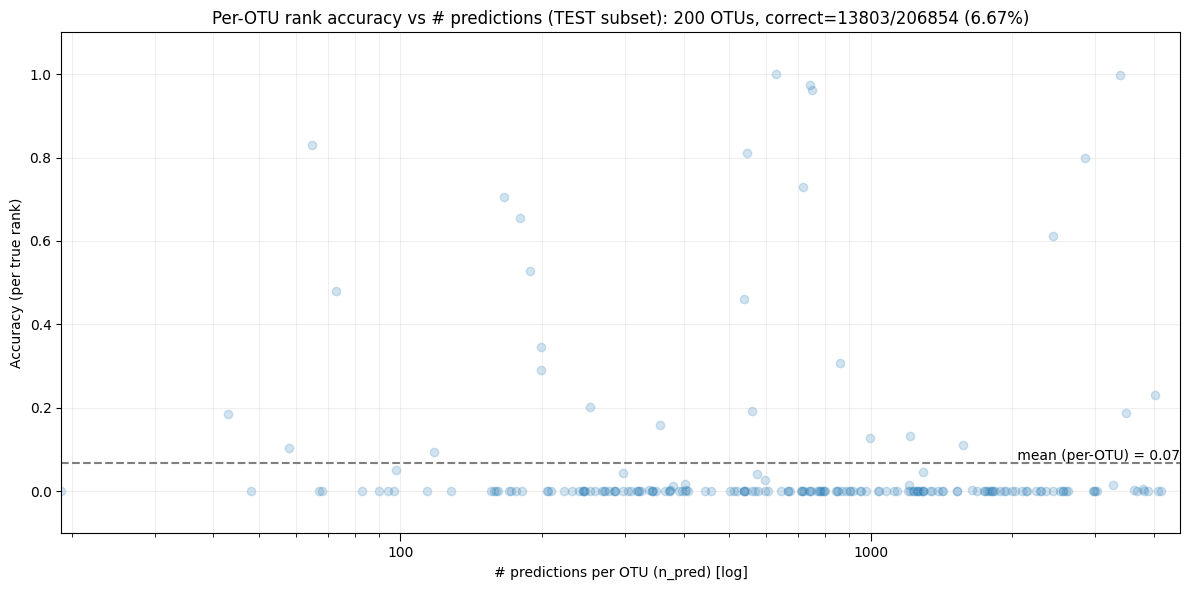

[INFO] multilabel eval: 172406 unique samples, 206854 predictions, 200 OTUs | correct=13803/206854 (6.67%)


In [ ]:
df_raw, df_otu, summary, fig = evaluate_and_plot_predictions_multilabel(
    jsonl_path=OUT_JSONL_AFFECTED,
    title_prefix="Per-OTU rank accuracy vs # predictions (TEST subset)"
)


In [ ]:
from otu_taxa.dataloaders_unk_balanced import build_tax2ancestor_at_rank, build_tax2rank_from_vocab 

RANKS = ("k","p","c","o","f","g","s")

# M_np must be the descendant closure used by the hierarchical loss: shape [T_base, T_base]
# tax_vocab_list must be length T_base (UNK-extended)
tax2rank = build_tax2rank_from_vocab(tax_vocab_unk)

ancestor_at_rank = {
    r: build_tax2ancestor_at_rank(
        M_np=M_np,                    # np.ndarray [T_base, T_base]
        tax_vocab_list=tax_vocab_unk,  # list[str] length T_base
        target_rank=r,
        missing_value=-1,
    )
    for r in RANKS
}

# quick sanity
for r in RANKS:
    assert len(ancestor_at_rank[r]) == M_np.shape[0]
print("[OK] built ancestor arrays for ranks:", RANKS)


[OK] built ancestor arrays for ranks: ('k', 'p', 'c', 'o', 'f', 'g', 's')


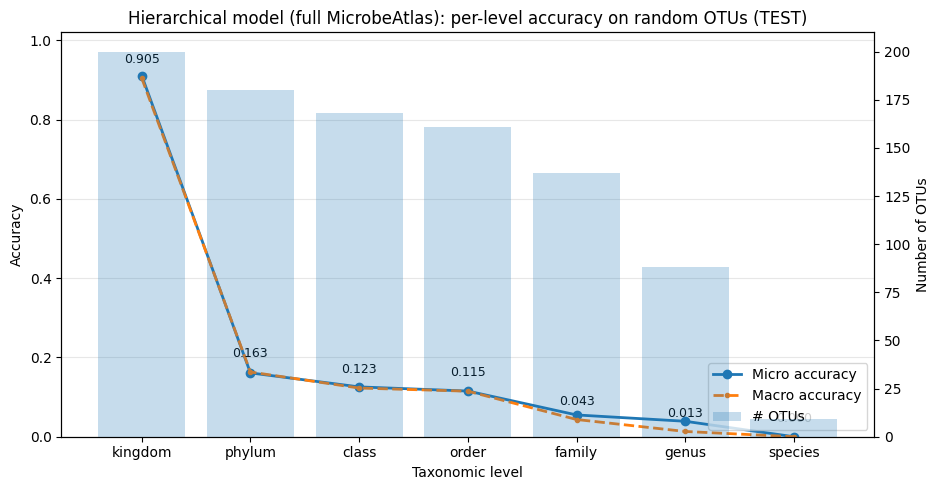

[INFO] overall micro (avg over levels) = 0.201, mean macro (avg over levels) = 0.195


,level,n_rows_used,n_otus_used,micro_acc,macro_acc
0,kingdom,206854,200,0.9110,0.9046
1,phylum,188230,180,0.1610,0.1632
2,class,176274,168,0.1257,0.1228
3,order,169101,161,0.1152,0.1149
4,family,146458,137,0.0549,0.0434
5,genus,92238,88,0.0390,0.0132
6,species,6732,9,0.0000,0.0000


In [ ]:
JSONL_PER_RANK = OUT_JSONL_AFFECTED  # your new predictions path

df_all, per_level_summary, overall, fig = plot_per_level_accuracy_hierarchical_from_arrays(
    jsonl_path=JSONL_PER_RANK,
    ancestor_at_rank=ancestor_at_rank,
    test_ids=None,  # optional; not needed if JSONL was generated strictly from test_ds
    ranks=("k","p","c","o","f","g","s"),
    title="Hierarchical model (full MicrobeAtlas): per-level accuracy on random OTUs (TEST)"
)

display(per_level_summary)


In [ ]:
RANKS = ("k","p","c","o","f","g","s")


# ------------------------------------------------------------
# 0) Build gold ancestor arrays 
# ------------------------------------------------------------
def build_ancestor_arrays_all_ranks(M_np, tax_vocab_unk, ranks=RANKS, missing_value=-1):
    """
    Returns dict rank -> dense list length T_base:
      ancestor_at_rank[r][t] = ancestor tax_id at rank r, else -1.
    """
    ancestor_at_rank = {}
    for r in ranks:
        ancestor_at_rank[r] = build_tax2ancestor_at_rank(
            M_np=M_np,
            tax_vocab_list=tax_vocab_unk,
            target_rank=r,
            missing_value=missing_value,
        )
    return ancestor_at_rank

Global rankACC: 0.2835


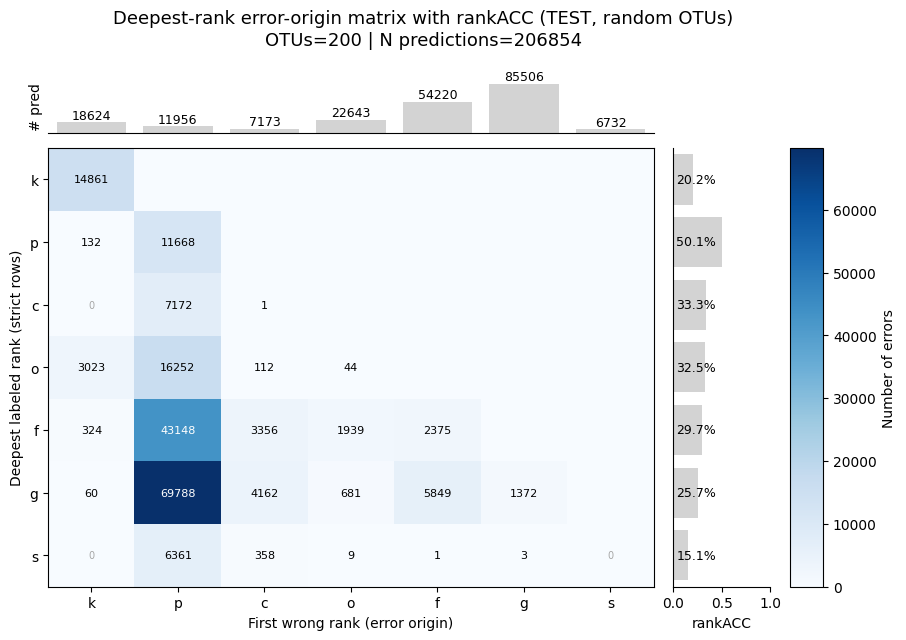

In [ ]:
# 1) Build ancestor arrays from the same artifacts used by the new model
ancestor_at_rank = build_ancestor_arrays_all_ranks(
    M_np=M_np,                 # [T_base, T_base] np.ndarray
    tax_vocab_unk=tax_vocab_unk,
    ranks=RANKS,
    missing_value=-1,
)

# 2) Load predictions, add pred/gold columns
df = load_predictions_with_pred_gold(
    jsonl_path=JSONL_PER_RANK,   # your JSONL path
    ancestor_at_rank=ancestor_at_rank,
    ranks=RANKS,
)

# 3) Strict matrix + meta for plot
counts_strict, meta_strict = strict_error_origin_matrix_and_rankACC(df, ranks=RANKS)

# 4) Plot
plot_strict_matrix_with_rankACC(
    counts_strict,
    meta_strict,
    title="Deepest-rank error-origin matrix with rankACC (TEST, random OTUs)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",   # or "otu_name" if your JSONL doesn’t have otu_id
    show_zeros_lower=True,
)

# 5) Global rankACC
global_rankACC, df_with_rankacc = compute_global_rankACC(df, ranks=RANKS)
print(f"Global rankACC: {global_rankACC:.4f}")


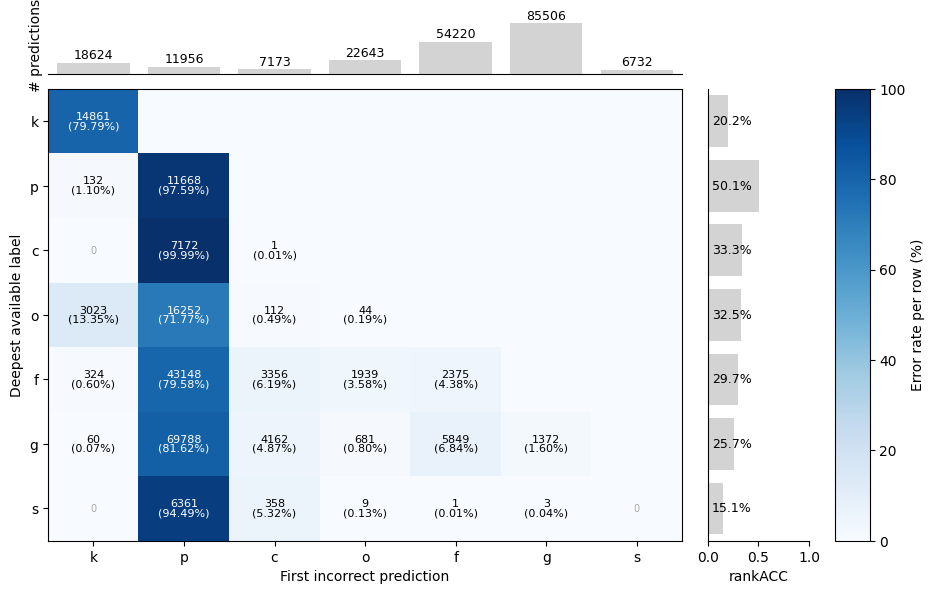

In [ ]:
fig, axes = plot_error_origin_matrix_rowpct_colored(
    counts_strict,
    meta_strict,
    title= "",#"Deepest-rank error origin (TEST)",
    ranks=RANKS,
    df=df,
    otu_col="otu_id",
    show_zeros_lower=True,
    show_percent_text=True,  # keep the per-cell row %
    vmax_pct=100.0,            # fixed 0–5% scale for comparability
    vmin_pct=0.0,
)
